### Shivanka Priyashan
### Index No : 190476V

#### Question 01

In [9]:
import numpy as np
import cv2 as cv
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt

N = 100
half_n = N//2
r = 10
s = r /16
t = np.random.uniform (0 , 2*np.pi , half_n )
n = s*np.random.randn( half_n )
x , y = (r + n)*np.cos(t) , (r + n)*np.sin(t)
X_circ = np.hstack(( x.reshape(half_n , 1 ) , y.reshape (half_n , 1 )))
m, b = -1, 2
x = np.linspace (-12, 12 , half_n )
y = m*x + b + s*np.random.randn( half_n )
X_line = np.hstack(( x.reshape ( half_n , 1 ) , y.reshape ( half_n , 1 ) ) )
X = np.vstack ( ( X_line ,X_circ  ) )

# plt.figure(figsize=(16,16))
# for point in X:
#    plt.scatter(point[0],point[1])
#    plt.axis("equal")
# plt.show()

In [30]:
import random

def circle_from3points(pointSet,iter_num,thresh):

    max_inlier_count = 0
    for i in range(iter_num):
        #Obtain index of 3 random points
        point1, point2, point3 = random.randint(0,len(pointSet)-1), random.randint(0,len(pointSet)-1),random.randint(0,len(pointSet)-1)
        x1,x2,x3 = pointSet[point1][0], pointSet[point2][0], pointSet[point3][0]
        y1,y2,y3 = pointSet[point1][1], pointSet[point2][1], pointSet[point3][1]

        A = np.array([[(x1**2 + y1**2), x1, y1, 1], [(x2**2 + y2**2), x2, y2, 1], [(x3**2 + y3**2), x3, y3, 1]])
        M_11 = np.linalg.det(A[:,1:])
        if M_11 == 0 : continue
        M_12 = np.linalg.det(np.concatenate((A[:,0].reshape((3,1)),A[:,2:].reshape((3,2))),axis = 1))     
        M_13 = np.linalg.det(np.concatenate((A[:,:2].reshape((3,2)),A[:,3].reshape((3,1))),axis = 1))   
        M_14 = np.linalg.det(A[:,:3])
        x0 = (1/2)*(M_12/M_11)
        y0 = (-1/2)*(M_13/M_11)
        r = np.sqrt(x0**2 + y0**2 + abs(M_14/M_11))

        if r > 10 : continue
        
        inlier_count, outlier_count = 0, 0
        inlier_points, outlier_points = [],[]
        
        for j in range(len(pointSet)):
            point = pointSet[j]
            x,y = point[0], point[1]
            distance = abs(np.sqrt((x - x0)**2 + (y - y0)**2) - r) 
            if distance < thresh:
                inlier_count+=1
                inlier_points.append(point)
            else:
                outlier_count+=1
                outlier_points.append(point)

        if inlier_count > max_inlier_count:
            max_inlier_count = inlier_count
            attr = [x0,y0,r]
            best_fit_pts = np.array([pointSet[point1],pointSet[point2],pointSet[point3]]).T
            selected_inliers = np.array(inlier_points).T
            selected_outliers = np.array(outlier_points).T

    return max_inlier_count, attr, best_fit_pts, selected_inliers, selected_outliers

Number of iterations:  34
RANSAC Inlier count:  48


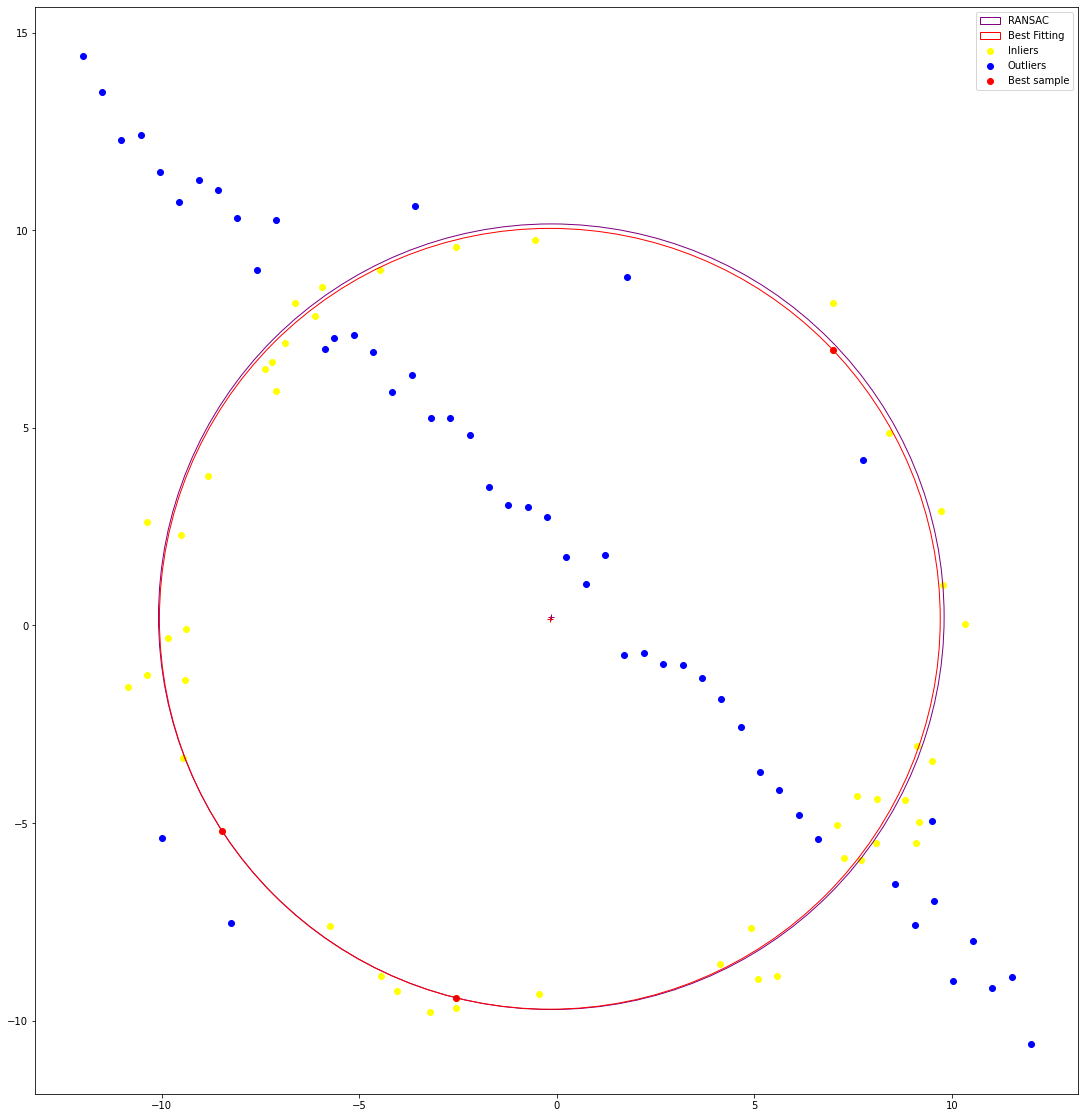

In [54]:
s = 3
t = 1                                       #threshold
e = 0.5                                     #outlier ratio
p = 0.99                                    #probability that at least one sample is free from outliers
N  = int(np.log(1-p)/ np.log(1-(1-e)**s))

fig, ax = plt.subplots(1,figsize=(20,20))

#######  RANSAC circle #########
RANSCAC_inlier_count, RANSAC_circle_attr, best_fit_pts, RANSAC_selected_inliers, RANSAC_selected_outliers = circle_from3points(X,N,t)
RANSAC_circle = plt.Circle((RANSAC_circle_attr[0],RANSAC_circle_attr[1]),RANSAC_circle_attr[2],fill=False,color='purple',label='RANSAC')
ax.add_patch(RANSAC_circle)
ax.plot(RANSAC_circle_attr[0],RANSAC_circle_attr[1],'+',color='purple')
ax.scatter(RANSAC_selected_inliers[0],RANSAC_selected_inliers[1],color='yellow',label='Inliers')
ax.scatter(RANSAC_selected_outliers[0],RANSAC_selected_outliers[1],color='blue',label='Outliers')

####### Best fitting circle ########
bestFitInlierCount, bestFitCircleAttr, bestFitPts, bestFitSI, bestFitSO = circle_from3points(RANSAC_selected_inliers.T,12000,t)
bestfit_circle = plt.Circle((bestFitCircleAttr[0],bestFitCircleAttr[1]),bestFitCircleAttr[2],fill=False,color='red',label='Best Fitting')
ax.add_patch(bestfit_circle)
ax.plot(bestFitCircleAttr[0],bestFitCircleAttr[1],'+',color='red')
ax.scatter(bestFitPts[0],bestFitPts[1],color='red', label='Best sample')

print('Number of iterations: ',N)
print('RANSAC Inlier count: ',RANSCAC_inlier_count)

ax.set_aspect('equal')
plt.legend(loc='upper right')
plt.show()

#### Question 02

##### Computing Homography

In [44]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

def MouseClick(event,x,y,flag,param):
    global im_temp, pts_dst
    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(im_temp, (x,y), 2, (0,0,255), 3, cv.LINE_AA)
        cv.imshow('Image',im_temp)
        if len(pts_dst) < 4:
            pts_dst = np.append(pts_dst,[(x,y)],axis=0)

def Homography(dst, src, alpha, beta):
    global im_temp, pts_dst
    dst_img = cv.imread(dst)
    dst_img_RGB = cv.cvtColor(dst_img,cv.COLOR_BGR2RGB)

    flag = cv.imread(src)
    flag_RGB = cv.cvtColor(flag,cv.COLOR_BGR2RGB)

    assert dst_img is not None
    assert flag is not None

    im_temp = dst_img.copy()

    pts_dst = np.empty((0,2))
    print(pts_dst)

    cv.namedWindow('Image',1)
    cv.imshow('Image',im_temp)
    cv.setMouseCallback("Image", MouseClick)
    cv.waitKey(0)

    bh, bw = dst_img.shape[0], dst_img.shape[1]
    fh, fw = flag.shape[0], flag.shape[1]

    pts_src = np.array([[0,0],[fw-1,0],[fw-1,fh-1],[0,fh-1]])

    hmg_matrix, status = cv.findHomography(pts_src, pts_dst)

    transformed_flag = cv.warpPerspective(flag, hmg_matrix, (bw,bh))
    transformed_flag_RGB = cv.cvtColor(transformed_flag,cv.COLOR_BGR2RGB)

    blended_image = cv.addWeighted(dst_img,alpha,transformed_flag,beta,0.0)
    blended_image_RGB = cv.cvtColor(blended_image,cv.COLOR_BGR2RGB)

    fig, ax = plt.subplots(4,1,figsize=(20,20))

    ax[0].imshow(dst_img_RGB)
    ax[0].set_title('Destination image')
    ax[0].axis('off')

    ax[1].imshow(flag_RGB)
    ax[1].set_title('Source image')
    ax[1].axis('off')

    ax[2].imshow(transformed_flag_RGB)
    ax[2].set_title('Warped image')
    ax[2].axis('off')

    ax[3].imshow(blended_image_RGB)
    ax[3].set_title('Blended image')
    ax[3].axis('off')

    plt.show()
    cv.imwrite('Blended image.jpg',blended_image)

    return 'Blended image.jpg'

[]


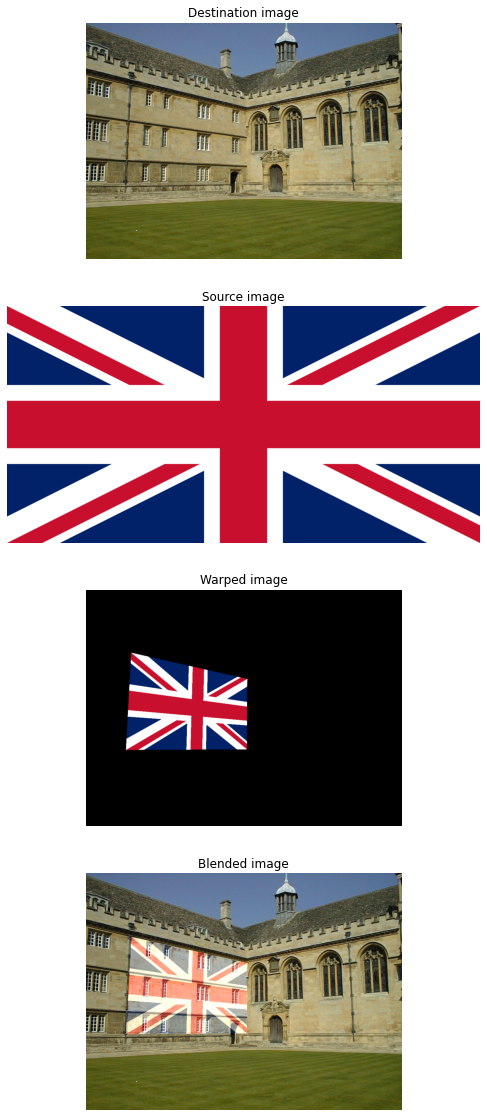

In [45]:
out1 = Homography('001.jpg','flag_uk.png',1,0.5)

[]


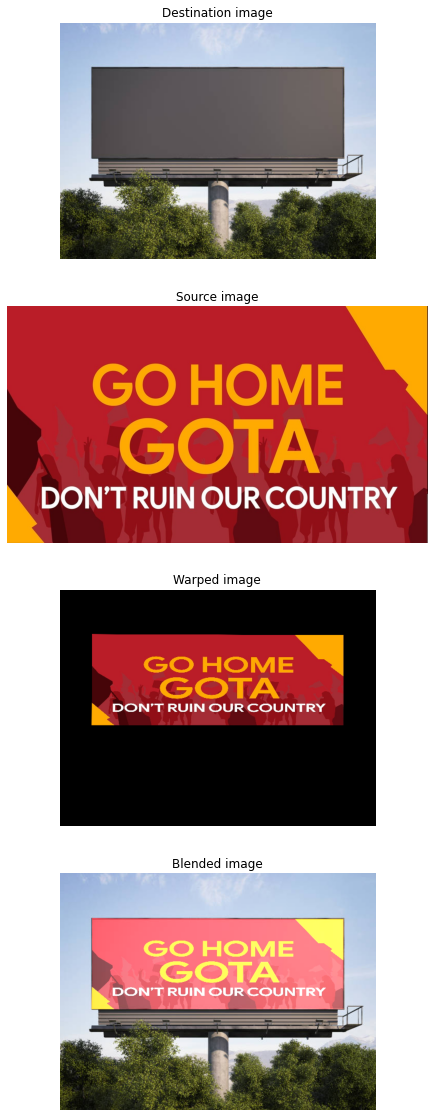

In [46]:
out2 = Homography('billboard_black.jpg','gotagohome.jpg',1,1)

[]


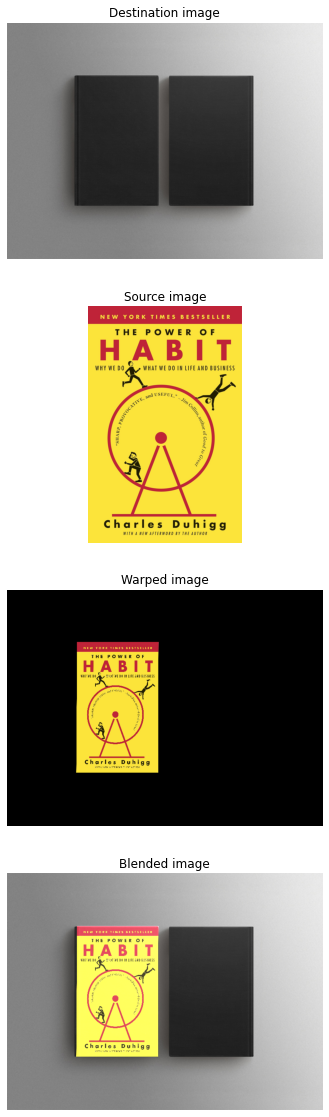

[]


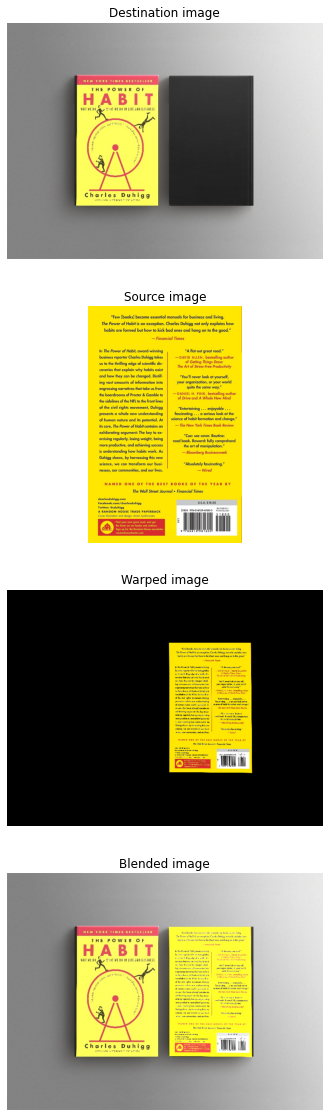

In [48]:
out3 = Homography(Homography('book.jpg','book_Front.jpg',1,1),'book_back.jpg',1,1)